1. **Set up the environment**: Ensure you have PySpark installed and set up in your Python environment.

2. **Load the data**: Import historical Bitcoin price data into a PySpark DataFrame.

3. **Preprocess the data**: Clean the data and prepare it for modeling (e.g., handling missing values, feature engineering).

4. **Feature extraction**: Extract features that can help in predicting the price (e.g., previous prices, volume, moving averages).

5. **Split the data**: Divide the data into training and test sets.

6. **Train the model**: Use a machine learning algorithm to train a predictive model on the training data.

7. **Evaluate the model**: Assess the performance of the model using the test data.

8. **Make predictions**: Use the trained model to make predictions on new data.

In [5]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lag, from_unixtime
from pyspark.sql.window import Window
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

In [3]:
spark = SparkSession.builder.appName("BitcoinPricePrediction").getOrCreate()

In [11]:
data = spark.read.csv("datasets/BTC-2021min.csv", header=True, inferSchema=True)

In [12]:
 # Step 3: Preprocess the data
# Convert unix timestamp to date
data = data.withColumn("date", from_unixtime(col("unix"), "yyyy-MM-dd HH:mm:ss"))

# Sort by date
data = data.orderBy("date")

# Feature engineering: create lag features
windowSpec = Window.orderBy("date")
data = data.withColumn("Prev_Close", lag("close", 1).over(windowSpec))

# Drop rows with null values created by lag
data = data.dropna()

In [13]:
data.show(10)

+----------+-------------------+-------+--------+--------+--------+--------+----------+-----------------+----------+
|      unix|               date| symbol|    open|    high|     low|   close|Volume BTC|       Volume USD|Prev_Close|
+----------+-------------------+-------+--------+--------+--------+--------+----------+-----------------+----------+
|1609459320|2021-01-01 03:32:00|BTC/USD| 29069.8|29073.02|29028.14|29035.89|3.03030144| 87987.4992786816|  29083.47|
|1609459380|2021-01-01 03:33:00|BTC/USD|29037.68|29069.39| 29019.0|29048.13|2.18962055| 63604.3823870715|  29035.89|
|1609459440|2021-01-01 03:34:00|BTC/USD|29048.13|29057.73|29035.61|29045.19| 1.4465376|  42014.959434144|  29048.13|
|1609459500|2021-01-01 03:35:00|BTC/USD|29021.86|29023.38|28982.33| 28999.5|1.06235967|  30807.899250165|  29045.19|
|1609459560|2021-01-01 03:36:00|BTC/USD|28996.71|29025.68|28996.71|28997.36|1.86322186| 54028.5150342896|   28999.5|
|1609459620|2021-01-01 03:37:00|BTC/USD|29000.96|29012.16|28983.

<AxesSubplot:title={'center':'BTC Price'}, xlabel='date'>

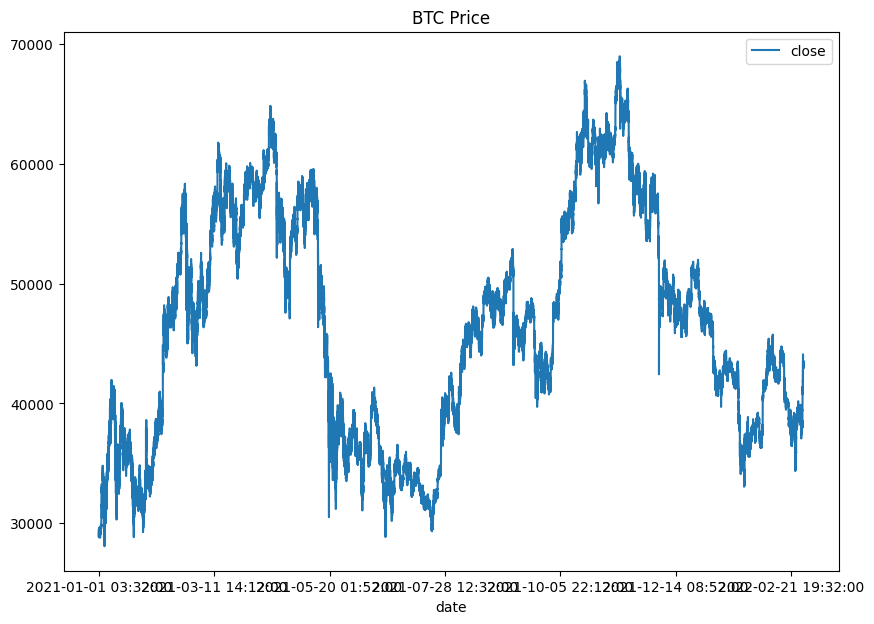

In [14]:
# plot the data
data_pd = data.toPandas()
data_pd.plot(x="date", y="close", figsize=(10, 7), title="BTC Price")

In [15]:
# Step 4: Feature extraction
assembler = VectorAssembler(inputCols=["Prev_Close"], outputCol="features")
data = assembler.transform(data)

data

DataFrame[unix: int, date: string, symbol: string, open: double, high: double, low: double, close: double, Volume BTC: double, Volume USD: double, Prev_Close: double, features: vector]

In [16]:
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

In [17]:
# Step 6: Train the model
lr = LinearRegression(featuresCol="features", labelCol="close")
lr_model = lr.fit(train_data)

In [18]:
# Step 7: Evaluate the model
predictions = lr_model.transform(test_data)
evaluator = RegressionEvaluator(labelCol="close", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 57.58300510701791


In [19]:
# Step 8: Make predictions
# Use the model to predict future prices
# Example previous close price, e.g., 43046.58
future_data = spark.createDataFrame([(43046.58,)], ["Prev_Close"])
future_data = assembler.transform(future_data)
future_predictions = lr_model.transform(future_data)
future_predictions.select("prediction").show()

+-----------------+
|       prediction|
+-----------------+
|43046.68996983619|
+-----------------+



In [20]:
# Stop the Spark session
spark.stop()